## 1. Load Requiremenets
Import all necessary libraries and load the T5 model and tokenizer from local files. Set up the device for computation.

In [1]:
# Load libraries, input, preprocess, and model
from transformers import T5ForConditionalGeneration, AutoTokenizer
import torch
try:
    import sentencepiece
except ImportError:
    print("Warning: sentencepiece is not installed. If you encounter tokenizer errors, run: pip install sentencepiece")

try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm

# Import helper functions from utils.py
import sys
sys.path.append('./code/utils')
from utils import (
    shuffle_decoder_ffns,
    shuffle_decoder_layers,
    extract_doc_id,
    evaluate_retrieval,
    evaluate_multiple_mlp_shuffles,
    evaluate_multiple_layer_shuffles,
    plot_value_distribution,
    plot_correct_map_heatmap,
    prepare_perms,   
)

# Input and preprocessing
model_path = "./DSI-large-7423"
tokenizer = AutoTokenizer.from_pretrained(model_path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Using device: cuda


## 2. Load and Prepare the NQ10k Test Dataset
Load the NQ10k test queries and prepare them as (query, gold_doc_id) pairs for evaluation.

In [2]:
# ---
# Load and Prepare the NQ10k Test Dataset
import json
import os

# Path to the test queries file
nq_test_path = os.path.join("NQ10k", "NQ10k", "test_queries-10000-7423.json")

# Load the test queries
with open(nq_test_path, "r") as f:
    nq_test_data = json.load(f)

# Prepare a list of (query, gold_doc_id) pairs
nq_eval_samples = []
for item in nq_test_data:
    query = item["query"]
    # Use the first relevant doc as the gold doc id, convert to string for comparison
    gold_doc_id = str(item["relevant_docs"][0])
    nq_eval_samples.append((query, gold_doc_id))

print(f"Loaded {len(nq_eval_samples)} test samples from NQ10k.")
# Show a sample
print("Sample:", nq_eval_samples[0])

Loaded 1000 test samples from NQ10k.
Sample: ('what is the name for the ch3coo- ion', '-590834235052106634')


Get statistics about the NQ10k dataset: number of queries per split, number of unique document IDs, and sample queries.

In [3]:
# Number of queries in each split and unique document IDs
import json
import os

splits = [
    ("train", "train_queries-10000-7423.json"),
    ("validation", "val_queries-10000-7423.json"),
    ("test", "test_queries-10000-7423.json")
]

split_stats = {}
unique_doc_ids = set()
for split_name, filename in splits:
    path = os.path.join("NQ10k", "NQ10k", filename)
    with open(path, "r") as f:
        data = json.load(f)
    split_stats[split_name] = len(data)
    for item in data:
        for doc_id in item["relevant_docs"]:
            unique_doc_ids.add(str(doc_id))

print("NQ10k Dataset Statistics:")
for split, count in split_stats.items():
    print(f"  {split.title()} queries: {count}")
print(f"  Unique document IDs (across all splits): {len(unique_doc_ids)}")

# Show a few example queries and their gold doc IDs from the test set
print("\nSample test queries:")
for i in range(3):
    print(f"  Query: {nq_eval_samples[i][0]}")
    print(f"  Gold doc ID: {nq_eval_samples[i][1]}")

NQ10k Dataset Statistics:
  Train queries: 12294
  Validation queries: 1000
  Test queries: 1000
  Unique document IDs (across all splits): 10000

Sample test queries:
  Query: what is the name for the ch3coo- ion
  Gold doc ID: -590834235052106634
  Query: who sang the theme song to the brady bunch
  Gold doc ID: 6224081265211326195
  Query: what does the winner of the rap game get
  Gold doc ID: 8844619839870903


## Priming Stage Analysis

In [4]:
# Evaluate model performance on the test set

# Move model to device and set to eval mode
model = T5ForConditionalGeneration.from_pretrained(model_path).to(device)
model.eval()

# Evaluate retrieval performance using the provided function
accuracy, total, correct = evaluate_retrieval(
    model=model,
    tokenizer=tokenizer,
    eval_samples=nq_eval_samples,
    device=device,
)

print("Retrieval Evaluation Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Total samples: {total}")
print(f"Correct predictions: {correct}")

Evaluating:   0%|          | 0/1000 [00:00<?, ?it/s]

Retrieval Evaluation Results:
Accuracy: 0.4140
Total samples: 1000
Correct predictions: 414


In [5]:
import random
import torch

def test_patch_priming_stage(
    model,
    tokenizer,
    eval_samples,
    device,
    max_len=32,
    limit=None
):
    """
    1. Picks one random (query, gold_doc_id) from eval_samples.
    2. Computes the fixed priming hidden at end of decoder Layer 6.
    3. Hooks into decoder.block[7] to overwrite its input with that fixed vector.
    4. Runs evaluate_retrieval on the patched model.
    5. Cleans up the hook and returns results.

    Returns:
        idx (int): index of the sample used
        accuracy (float)
        total (int)
        correct (int)
    """
    # 1) Random sample
    idx = random.randrange(len(eval_samples))
    random_query, _ = eval_samples[idx]

    # 2) Compute fixed hidden at end of Layer 6
    with torch.no_grad():
        enc = tokenizer(random_query, return_tensors="pt").to(device)
        dec_start = torch.tensor(
            [[model.config.decoder_start_token_id]],
            device=device,
        )
        out = model(
            input_ids=enc.input_ids,
            attention_mask=enc.attention_mask,
            decoder_input_ids=dec_start,
            output_hidden_states=True,
        )
    # decoder_hidden_states[7] is the hidden *after* Layer 6
    fixed_hidden = out.decoder_hidden_states[7][0, 0].detach()  # (d_model,)

    # 3) Hook to overwrite block 7 input
    def _patch_priming(module, inputs):
        hs, *rest = inputs
        bsz, seq_len, d = hs.shape
        patched = fixed_hidden.unsqueeze(0).unsqueeze(1).expand(bsz, seq_len, d)
        return (patched, *rest)

    handle = model.decoder.block[7].register_forward_pre_hook(_patch_priming)

    # 4) Evaluate
    accuracy, total, correct = evaluate_retrieval(
        model=model,
        tokenizer=tokenizer,
        eval_samples=eval_samples,
        device=device,
        max_len=max_len,
        verbose=False,
        limit=limit,
    )

    # 5) Cleanup
    handle.remove()
    return idx, accuracy, total, correct


In [6]:
for run in range(5):
    idx, acc, tot, cor = test_patch_priming_stage(
        model=model,
        tokenizer=tokenizer,
        eval_samples=nq_eval_samples,
        device=device,
        max_len=32,
        limit=None,
    )
    print(f"Run {run+1}: sample #{idx} → Accuracy: {acc:.4f} ({cor}/{tot})")


Evaluating:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 1: sample #353 → Accuracy: 0.4110 (411/1000)


Evaluating:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 2: sample #551 → Accuracy: 0.4240 (424/1000)


Evaluating:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 3: sample #909 → Accuracy: 0.4070 (407/1000)


Evaluating:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 4: sample #103 → Accuracy: 0.4110 (411/1000)


Evaluating:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 5: sample #155 → Accuracy: 0.4170 (417/1000)


Mean cosine sim: 0.9985977
Std  cosine sim: 0.0005427622


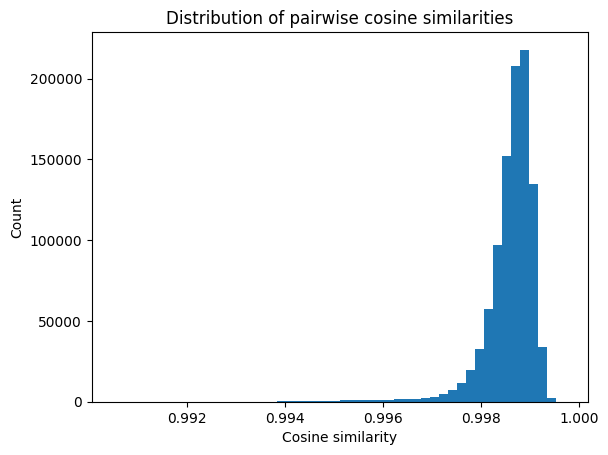

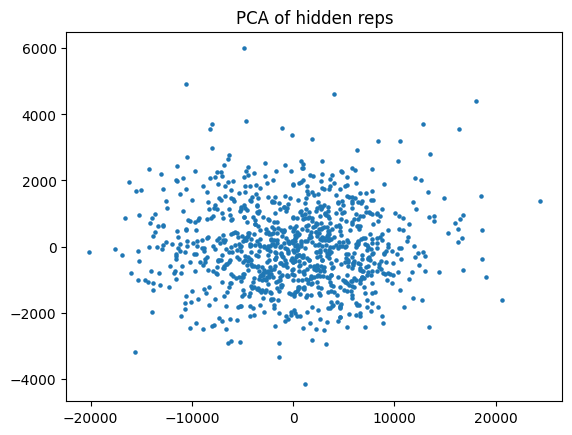

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Move model to device and set to eval mode
model = T5ForConditionalGeneration.from_pretrained(model_path).to(device)
model.eval()

def collect_hidden_reps(model, tokenizer, samples, device, layer_idx=7):
    """
    Returns H: tensor [N, d_model] of the hidden at decoder_hidden_states[layer_idx]
    """
    model.eval()
    reps = []
    for query, _ in tqdm(samples, desc="Collecting reps"):
        enc = tokenizer(query, return_tensors="pt").to(device)
        dec_start = torch.tensor(
            [[model.config.decoder_start_token_id]], device=device
        )
        with torch.no_grad():
            out = model(
                input_ids=enc.input_ids,
                attention_mask=enc.attention_mask,
                decoder_input_ids=dec_start,
                output_hidden_states=True,
            )
        # pick out the first token's embedding at the given layer
        h = out.decoder_hidden_states[layer_idx][0, 0].cpu()  # [d_model]
        reps.append(h)
    return torch.stack(reps, dim=0)  # [N, d_model]

# ——— Usage ———
H = collect_hidden_reps(model, tokenizer, nq_eval_samples, device)

# Normalize and compute cosine‐sim matrix
Hn    = H / H.norm(dim=1, keepdim=True)
S     = Hn @ Hn.t()              # [N,N]
mask  = ~torch.eye(S.size(0), dtype=bool)
sims  = S[mask].numpy()          # off‐diagonals only

# Summaries
print("Mean cosine sim:", sims.mean())
print("Std  cosine sim:", sims.std())

# Histogram
plt.figure()
plt.hist(sims, bins=50)
plt.title("Distribution of pairwise cosine similarities")
plt.xlabel("Cosine similarity")
plt.ylabel("Count")
plt.show()

# (Optional) PCA scatter
from sklearn.decomposition import PCA
proj = PCA(2).fit_transform(H.numpy())  # [N,2]
plt.figure()
plt.scatter(proj[:,0], proj[:,1], s=5)
plt.title("PCA of hidden reps")
plt.show()


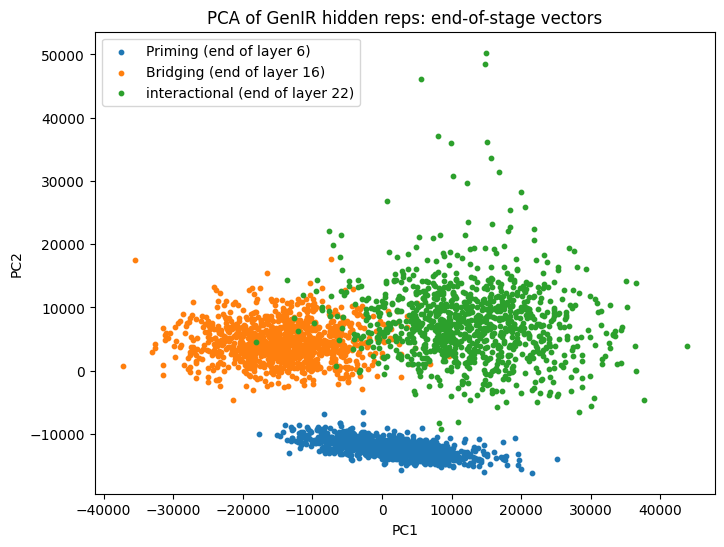

In [8]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tqdm import tqdm

def collect_hidden_reps(model, tokenizer, samples, device, layer_idx):
    """
    Runs each query through the decoder, grabs the hidden state
    of the *first* token at decoder_hidden_states[layer_idx].
    Returns a tensor of shape [N, d_model].
    """
    reps = []
    model.eval()
    for q, _ in tqdm(samples, desc=f"Collecting layer {layer_idx} reps"):
        enc = tokenizer(q, return_tensors="pt").to(device)
        dec_start = torch.tensor(
            [[model.config.decoder_start_token_id]],
            device=device
        )
        with torch.no_grad():
            out = model(
                input_ids=enc.input_ids,
                attention_mask=enc.attention_mask,
                decoder_input_ids=dec_start,
                output_hidden_states=True,
            )
        h = out.decoder_hidden_states[layer_idx][0, 0].cpu()  # [d_model]
        reps.append(h)
    return torch.stack(reps, 0)  # [N, d_model]

# ————— Define stage boundaries (for T5-base with 12 decoder layers) —————
# hidden_states indices: 0=embed, 1=after layer0, …, 12=after layer11
stage_layers = {
    "Priming (end of layer 6)": 7,
    "Bridging (end of layer 16)": 17,
    "interactional (end of layer 22)": 22,
}

# ————— Collect one matrix per stage —————
H_by_stage = {}
for name, idx in stage_layers.items():
    H_by_stage[name] = collect_hidden_reps(
        model, tokenizer, nq_eval_samples, device, layer_idx=idx
    )

# ————— Stack them and build labels —————
H_all = torch.cat(list(H_by_stage.values()), dim=0)  # [3N, d_model]
labels = []
for name, H in H_by_stage.items():
    labels += [name] * H.size(0)

# ————— PCA projection —————
proj = PCA(n_components=2).fit_transform(H_all.numpy())  # [3N, 2]

# ————— Scatter plot —————
plt.figure(figsize=(8,6))
for stage_name in stage_layers:
    mask = [lab == stage_name for lab in labels]
    plt.scatter(
        proj[mask, 0],
        proj[mask, 1],
        s=10,
        label=stage_name
    )
plt.legend()
plt.title("PCA of GenIR hidden reps: end-of-stage vectors")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
